In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from os import listdir
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from joblib import dump, load

In [2]:
stocks = ["aapl.csv", "nke.csv", "pfe.csv", "ko.csv", "dis.csv"]
input_data = []
for stock in stocks:
    NAME = stock.split(".")[0].upper()
    folder = "prepared_stock_data"
    data = pd.read_csv(folder + "//" + stock, index_col = "Unnamed: 0").drop(['Label'],axis=1)
    folder = "stock_data"
    prices = pd.read_csv(folder + "//" + stock, index_col = "Date")["Close"]
    prices = prices.loc["2019-01-01":"2020-01-01"]
    data = data.loc["2019-01-01":"2020-01-01"]
    dates = data.index
    X = np.asanyarray(data.drop("Name", axis = 1))
    X = torch.tensor(X).float()
    input_data.append((NAME, X, prices))
    print(NAME, X[:1,:], prices.head(3))

AAPL tensor([[-0.1075, -0.1235, -0.1198, -0.1133, -0.1133, -0.1130, -0.0992, -0.0860,
         -0.0761, -0.0502, -0.0579, -0.0596, -0.0530, -0.0118,  0.0154, -0.0361,
         -0.0192, -0.0032, -0.0122, -0.0332, -0.1317, -0.0971, -0.1660, -0.1841,
         -0.1769, -0.2501, -0.3195, -0.3161, -0.2639, -0.1236, -0.0166]]) Date
2019-01-02    154.79
2019-01-03    139.38
2019-01-04    145.33
Name: Close, dtype: float64
NKE tensor([[ 0.1562,  0.1503,  0.1271,  0.1061,  0.1064,  0.0932,  0.0805,  0.0794,
          0.0854,  0.0906,  0.0906,  0.0877,  0.0951,  0.1049,  0.1783,  0.1299,
          0.1234,  0.1545,  0.1164,  0.1180,  0.1011,  0.0942,  0.0771, -0.0213,
         -0.0476, -0.0706, -0.0803, -0.1343, -0.0008,  0.0097, -0.0159]]) Date
2019-01-02    72.90
2019-01-03    71.61
2019-01-04    73.48
Name: Close, dtype: float64
PFE tensor([[ 0.2128,  0.2014,  0.2010,  0.2106,  0.2128,  0.2074,  0.2081,  0.1975,
          0.1453,  0.1690,  0.1777,  0.2088,  0.2092,  0.2132,  0.2953,  0.2597,
  

In [3]:
class DNN_Model1(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2, p=0.5):
        super(DNN_Model1, self).__init__()
        self.drop = nn.Dropout(p = p)
        self.channel1_l1 = nn.Linear(D_in, H1)
        self.channel1_l2 = nn.Linear(H1, H2)
        self.channel1_l3 = nn.Linear(H2, H3)
        
        self.channel2_l1 = nn.Linear(D_in, H1)
        self.channel2_l2 = nn.Linear(H1, H2)
        self.channel2_l3 = nn.Linear(H2, H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.drop(self.channel1_l1(x)), self.drop(self.channel2_l1(x)))
        x = torch.max(self.drop(self.channel1_l2(x)), self.drop(self.channel2_l2(x)))
        x = torch.max(self.drop(self.channel1_l3(x)), self.drop(self.channel2_l3(x)))
        x = F.softmax(self.out(x))
        return x

In [4]:
class DNN_Carlos(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2):
        super(DNN_Carlos, self).__init__()
        self.drop1 = nn.Dropout(p = 0.5)
        self.drop2 = nn.Dropout(p = 0.25)
        
        self.linear1_1 = nn.Linear(D_in, H1)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear1_1.weight)
        self.linear2_1 = nn.Linear(H1, H2)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear2_1.weight)
        self.linear3_1 = nn.Linear(H2, H3)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear3_1.weight)
        self.linear1_2 = nn.Linear(D_in, H1)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear1_2.weight)
        self.linear2_2 = nn.Linear(H1, H2)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear2_2.weight)
        self.linear3_2 = nn.Linear(H2, H3)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear3_2.weight)
        
        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.bn1(self.drop1(self.linear1_1(x))), self.bn1(self.drop1(self.linear1_2(x))))
        x = torch.max(self.bn2(self.drop2(self.linear2_1(x))), self.bn2(self.drop2(self.linear2_2(x))))
        x = torch.max(self.bn3(self.linear3_1(x)), self.bn3(self.linear3_2(x)))
        x = F.softmax(self.out(x))
        return x

In [5]:
def test_case(NAME, signals):
    budget = 100000
    investment = 0
    prevSignal = -1
    prevPrice = -1
    for i, date in enumerate(dates):
        inf = signals.loc[date]
        curSignal = inf["Signal"]
        curPrice = inf["Price"]
        if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
            investment += budget
            budget = 0
            prevPrice = curPrice
            #print(date, "BUY, INVESTMENT: $", np.round(investment,3), curPrice)
        elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
            budget = curPrice/prevPrice * investment
            investment = 0
            #print(date, "SELL, BUDGET   : $",np.round(budget,3), curPrice)
        prevSignal = curSignal

    print(NAME)
    print("final budget: $", budget)
    print("Return: ", budget/100000 - 1)
    return budget/100000 - 1

In [6]:
def plot_trading(NAME, signals, RETURN):
    information = signals.loc["2019-01-01":"2019-08-01"]
    plt.figure(figsize = (14,7))
    plt.title(NAME + " DNN Signals. Return: " + str(RETURN), fontsize = 8)
    plt.plot(information["Price"], color = "gray", label = "Closing Price")
    plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
    plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY/HOLD")
    plt.legend()

    plt.xticks(information.index[::15], fontsize = 16, rotation = 45)
    plt.yticks(fontsize = 16)
    plt.show()

In [7]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
dropout_rate = 0.5

In [8]:
PATH = "models//model1_2019.pth"
DNN_model = DNN_Model1(input_dim, hidden1, hidden2, hidden3, out_dim, dropout_rate)
DNN_model.load_state_dict(torch.load(PATH))
DNN_model.eval()

DNN_Model1(
  (drop): Dropout(p=0.5, inplace=False)
  (channel1_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel1_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel1_l3): Linear(in_features=10, out_features=5, bias=True)
  (channel2_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel2_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel2_l3): Linear(in_features=10, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

In [9]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
DNNCarlos_Model = DNN_Carlos(input_dim, hidden1, hidden2, hidden3, out_dim)

In [10]:
PATH = "models//modelCarlos_2019.pth"
DNNCarlos_Model.load_state_dict(torch.load(PATH))
DNNCarlos_Model.eval()

DNN_Carlos(
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (linear1_1): Linear(in_features=31, out_features=31, bias=True)
  (linear2_1): Linear(in_features=31, out_features=10, bias=True)
  (linear3_1): Linear(in_features=10, out_features=5, bias=True)
  (linear1_2): Linear(in_features=31, out_features=31, bias=True)
  (linear2_2): Linear(in_features=31, out_features=10, bias=True)
  (linear3_2): Linear(in_features=10, out_features=5, bias=True)
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

## Deep Neural Network Model Returns

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AAPL
final budget: $ 136293.86042209459
Return:  0.3629386042209459


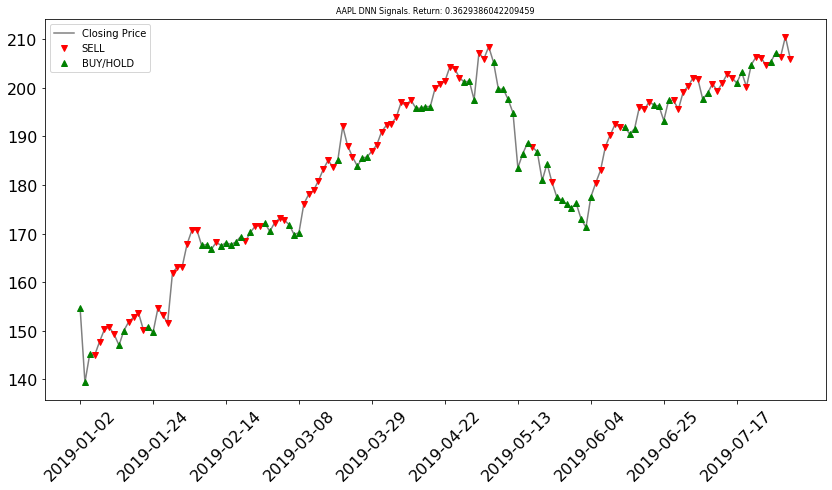

NKE
final budget: $ 118188.33837272355
Return:  0.18188338372723556


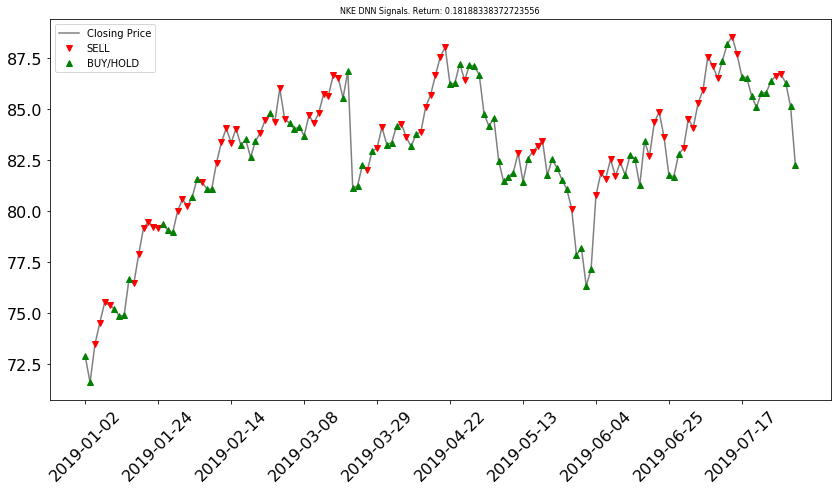

PFE
final budget: $ 87352.79122052499
Return:  -0.12647208779475017


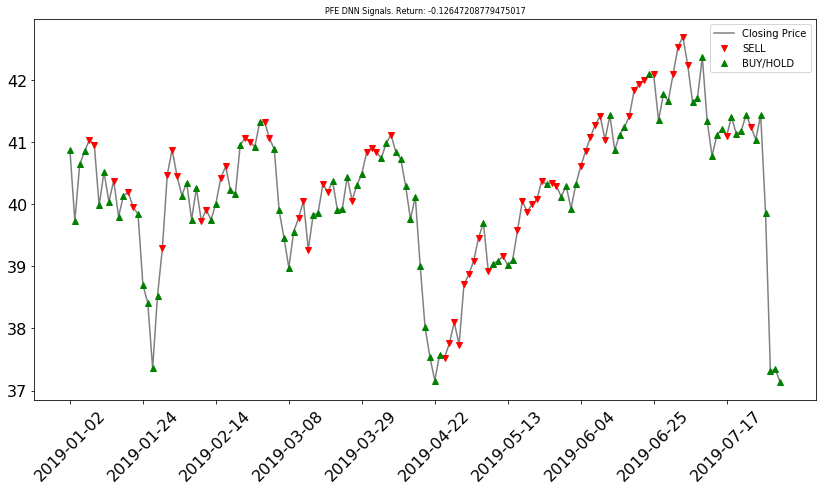

KO
final budget: $ 119348.1907649197
Return:  0.19348190764919693


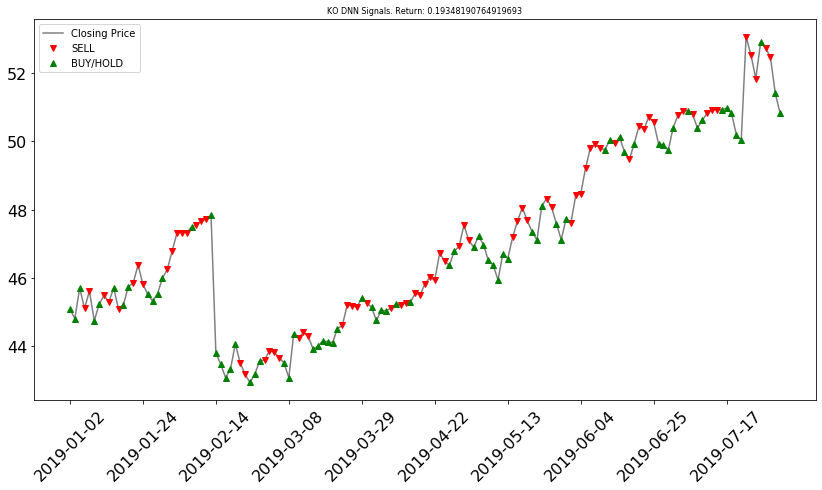

DIS
final budget: $ 130788.42572895045
Return:  0.3078842572895044


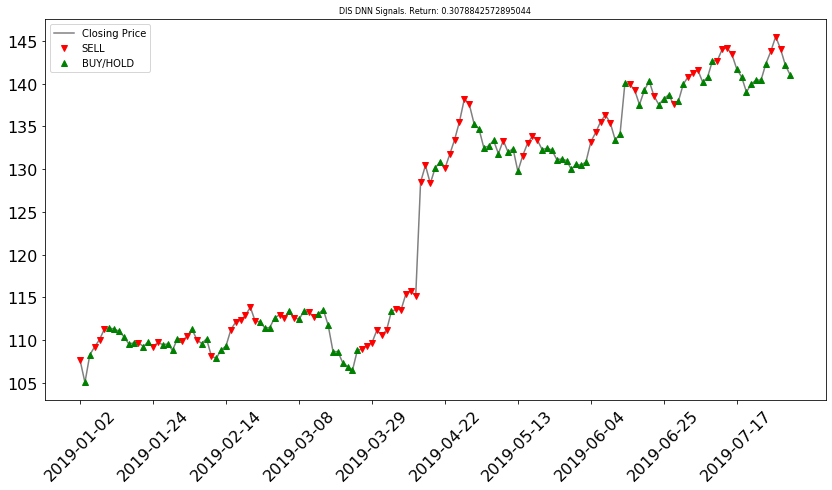

In [11]:
output_data = []
for NAME, X, PRICES in input_data:
    z = DNN_model(X)
    _, y_hat = torch.max(z,1)
    y_hat = y_hat.numpy()
    dates = PRICES.index
    signalsDNN = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsDNN))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, signal, RETURN)

## Carlos' DNN Model Returns

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AAPL
final budget: $ 182572.8589567378
Return:  0.8257285895673778


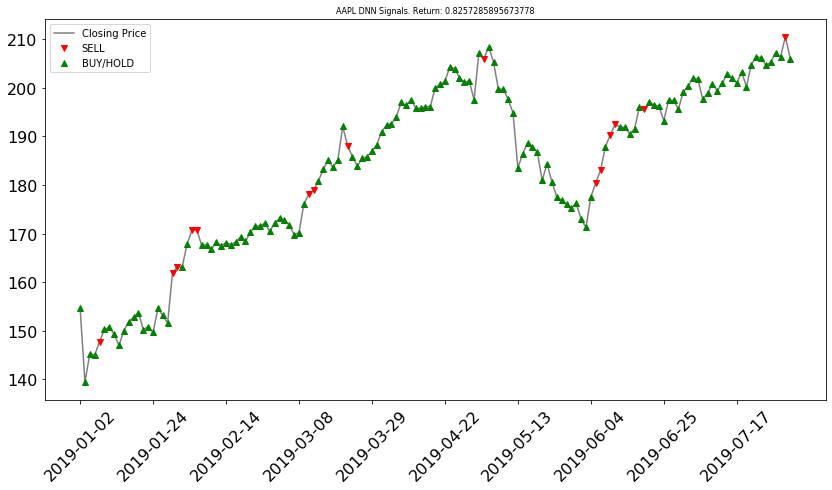

NKE
final budget: $ 129274.03821070294
Return:  0.29274038210702935


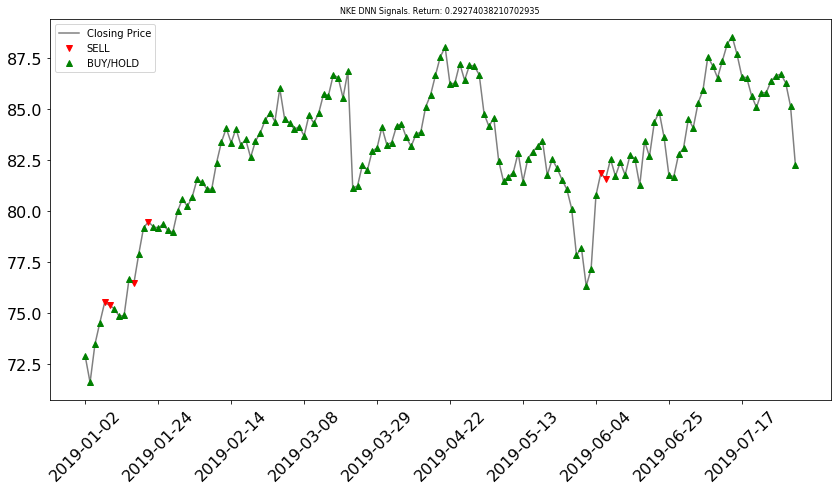

PFE
final budget: $ 95186.61991788764
Return:  -0.04813380082112362


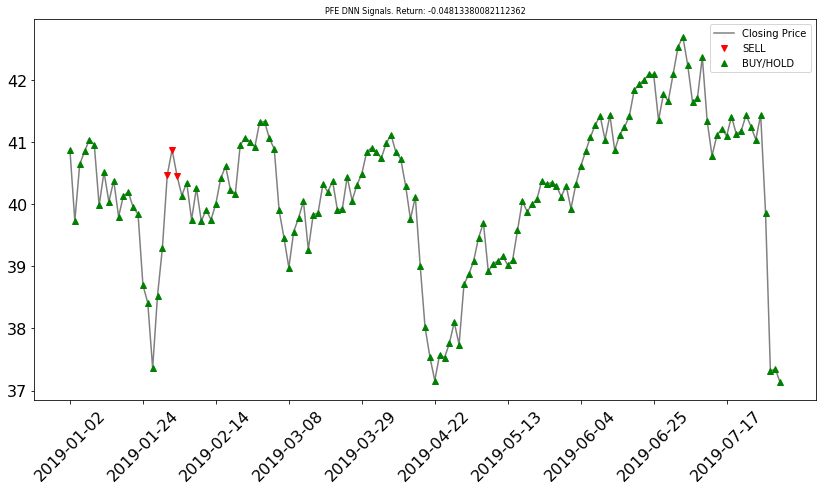

KO
final budget: $ 123309.66924176336
Return:  0.23309669241763364


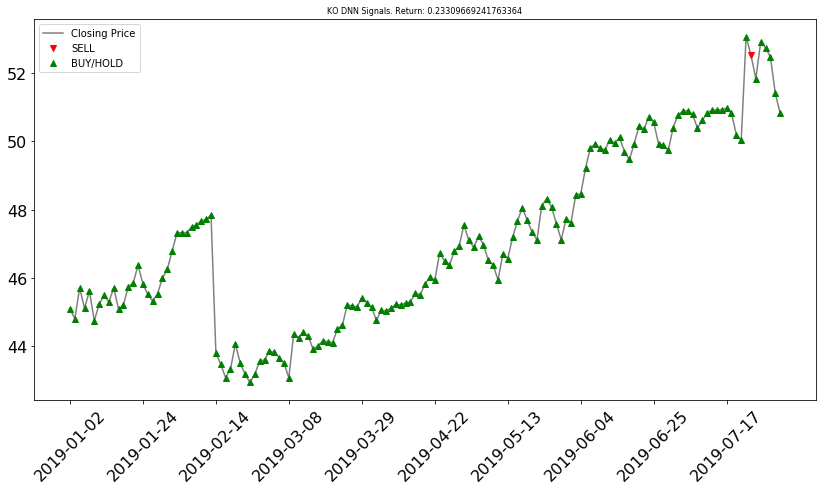

DIS
final budget: $ 137506.85527087946
Return:  0.3750685527087947


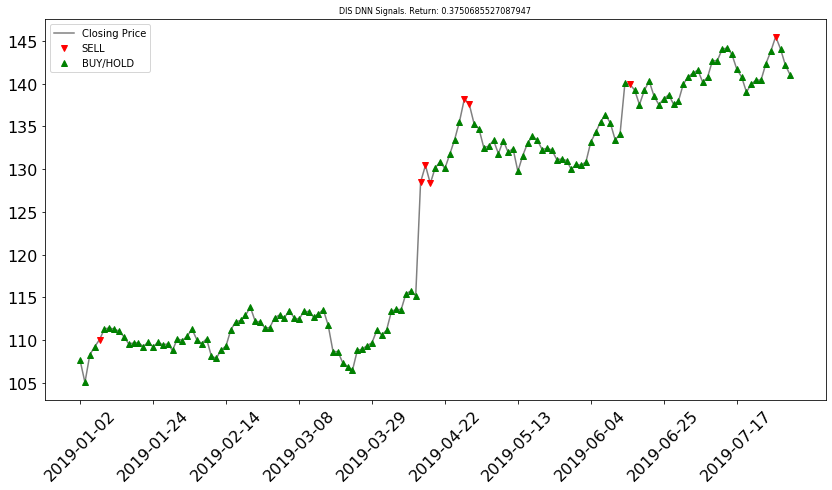

In [12]:
output_data = []
for NAME, X, PRICES in input_data:
    z = DNNCarlos_Model(X)
    _, y_hat = torch.max(z,1)
    y_hat = y_hat.numpy()
    dates = PRICES.index
    signalsDNNCarlos = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsDNNCarlos))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, signal, RETURN)

## Random Forest Model Returns

In [13]:
modelRF = load('RandomForest2019.joblib')

AAPL
final budget: $ 136886.49097125107
Return:  0.36886490971251074


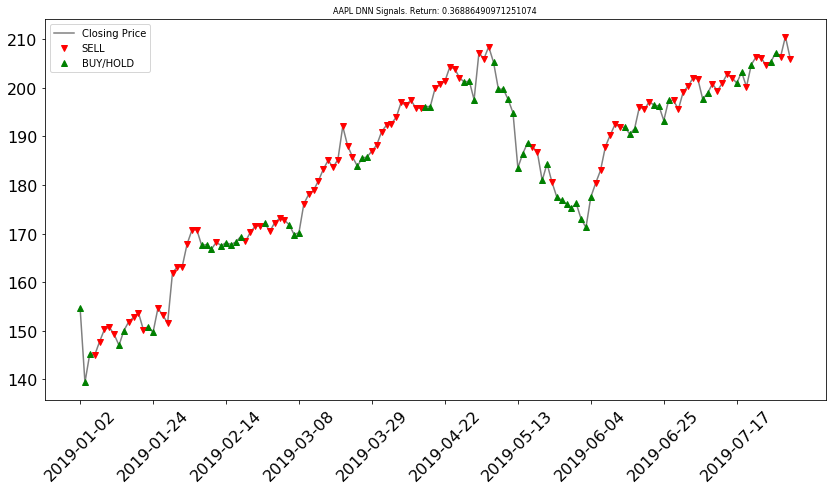

NKE
final budget: $ 115088.89415725342
Return:  0.1508889415725343


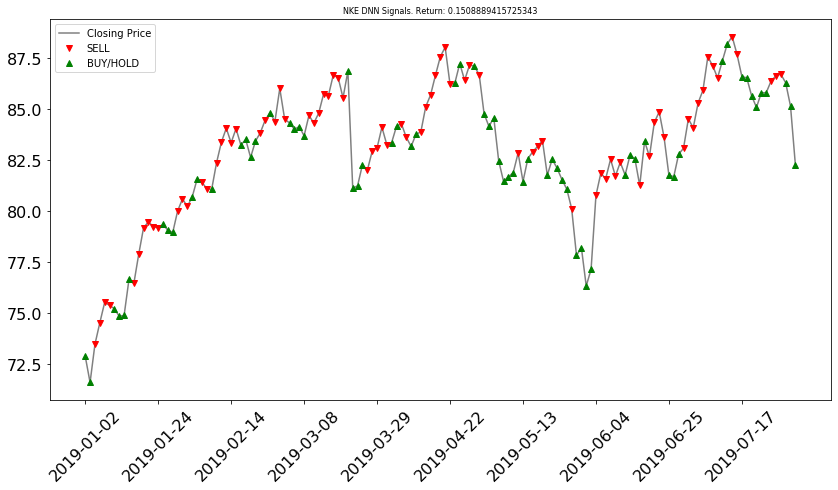

PFE
final budget: $ 88863.17453499073
Return:  -0.1113682546500927


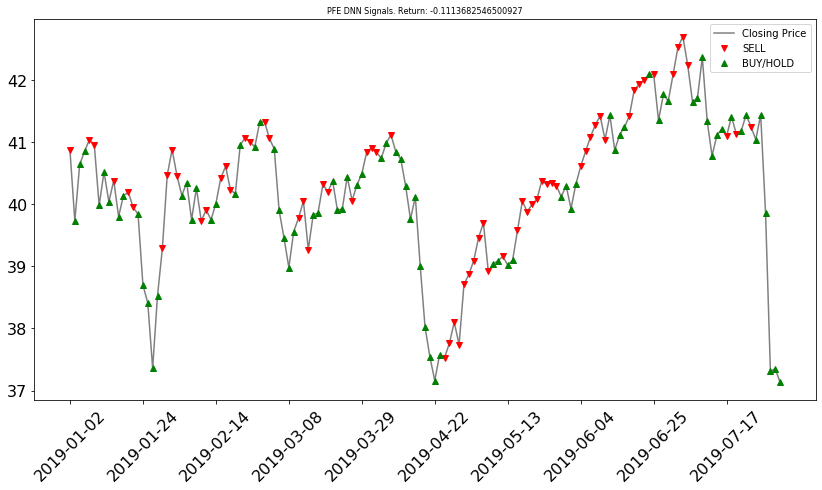

KO
final budget: $ 121850.49654256024
Return:  0.21850496542560238


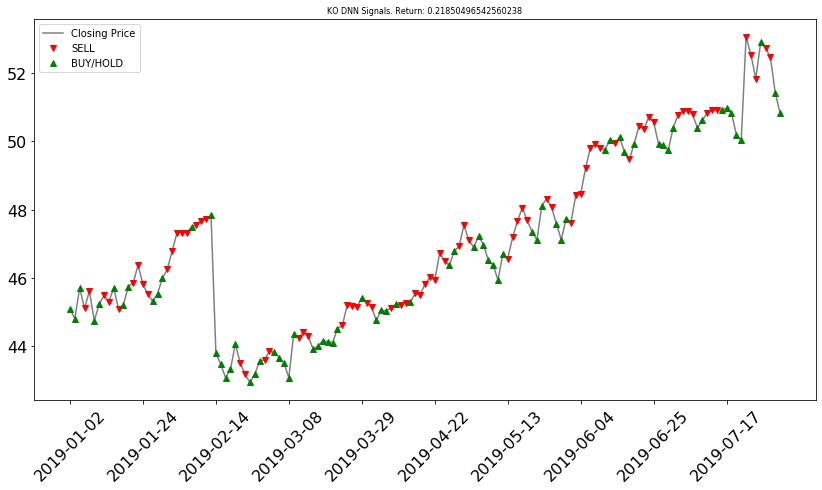

DIS
final budget: $ 130990.70380005868
Return:  0.30990703800058683


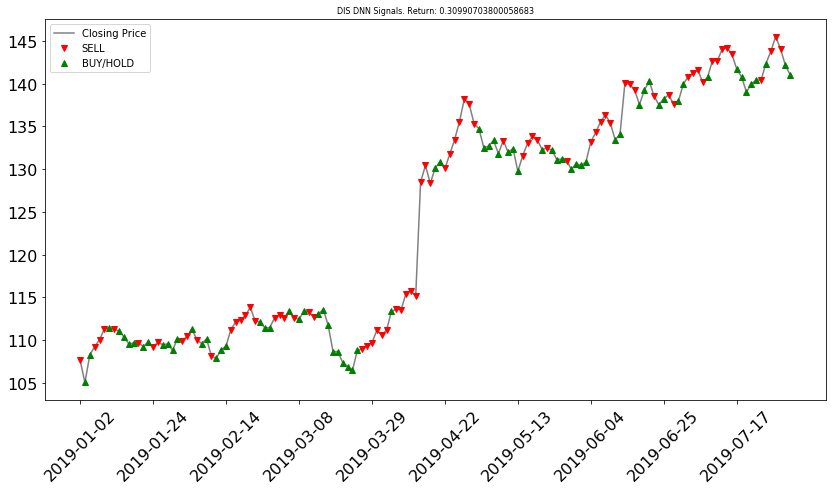

In [14]:
output_data = []
for NAME, X, PRICES in input_data:
    y_hat = modelRF.predict(X.numpy())
    dates = PRICES.index
    signalsRF = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsRF))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, signal, RETURN)

## Gradient Boost Trees Model Returns

In [15]:
modelGB = load('GBT_2019.joblib')

AAPL
final budget: $ 111771.76668880442
Return:  0.11771766688804419


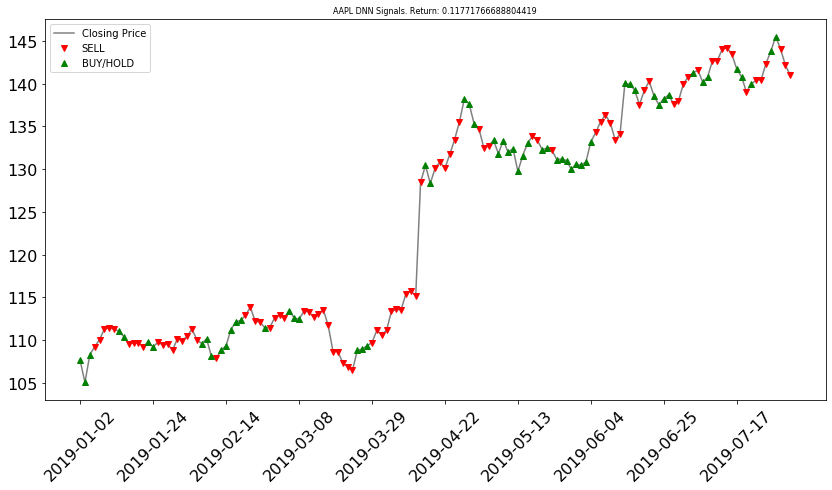

NKE
final budget: $ 124563.87463485594
Return:  0.24563874634855942


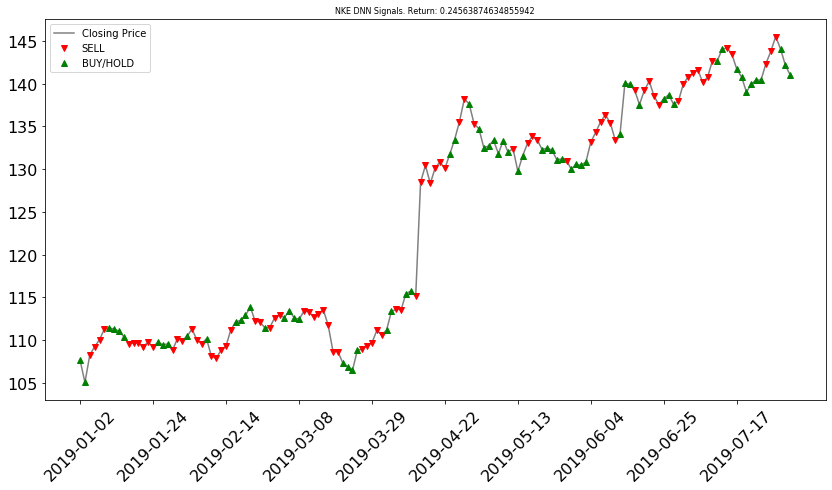

PFE
final budget: $ 132872.44459403623
Return:  0.32872444594036243


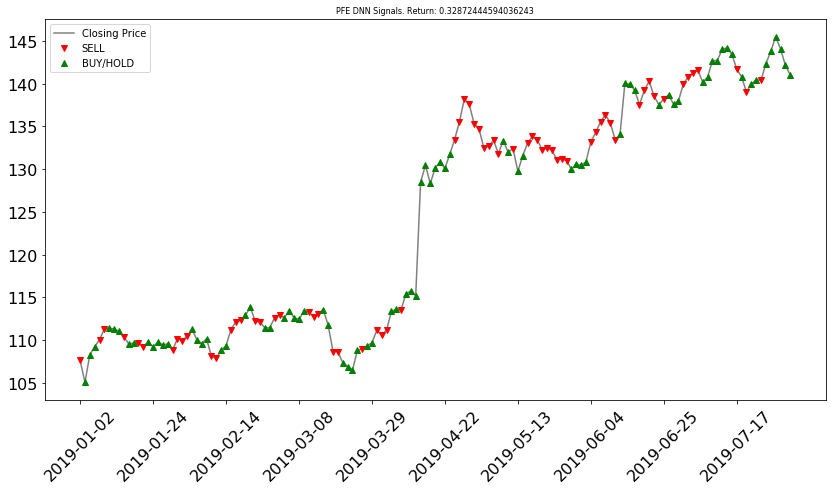

KO
final budget: $ 119454.2352857876
Return:  0.19454235285787602


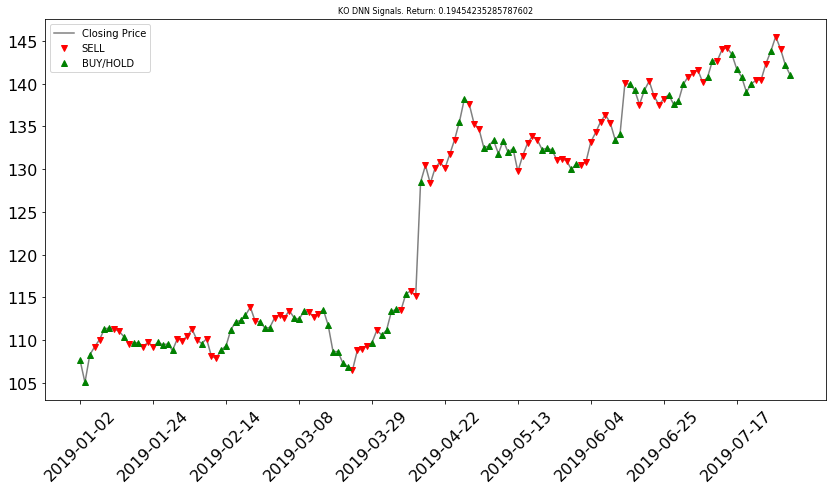

DIS
final budget: $ 132379.16199803032
Return:  0.32379161998030326


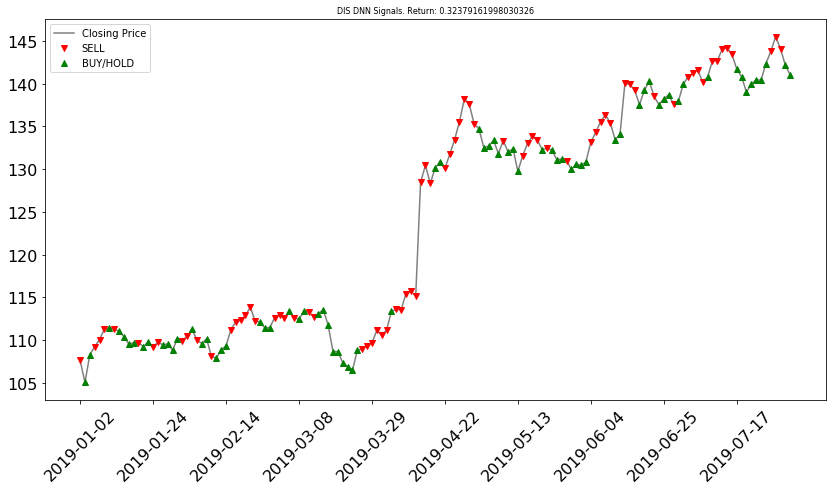

In [16]:
output_data = []
for NAME, X, PRICES in input_data:
    y_hat = modelGB.predict(X.numpy())
    dates = PRICES.index
    signalsGB = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
    output_data.append((NAME, signalsGB))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, signal, RETURN)
